# Смирнов Сергей ФПэ-01-22

По аналогии с решением задач из практики, построить график зависимости $\eta_{oi} = f(H_0)$ в диапазоне $H_0$ = (50 - 150) $\frac {kJ}{kg}$. $\eta_{ол}$ = 78%. $u = 160 m/s$. Все остальные переменные и условия принять такие же как на практическом занятии.


In [1]:
import iapws
from iapws import IAPWS97 as gas

MPa = 10 ** 6
kPa = 10 ** 3
unit = 1 / MPa
to_kelvin = lambda x: x + 273.15 if x else None

In [6]:
def get_k_frictions(s_div_r, re):
    return 2.5 * 10 ** (-2) * s_div_r ** 0.1 * re **(-0.2)
    
def get_friction_loss_pu(k, d, u_div_dummy_speed, F):
    return k * d ** 2 * u_div_dummy_speed ** 3 / F 
    
def get_ventilation_loss_pu(m, k, sin, e, u_div_dummy_speed):
    first = k / sin
    second = (1 - e) / e
    third = u_div_dummy_speed ** 3
    
    return first * second * third * m
    
def get_segment_loss_pu(B, l, F, u_div_dummy_speed, blade_efficiency, segments):
    first = 0.25 * B * l / F
    second = u_div_dummy_speed * blade_efficiency * segments
    return first * second
    
def compute_equal_gap(z, delta_r, mu_r, delta_a, mu_a):
    first = 1 / (mu_a * delta_a) ** 2
    second = z / (mu_r * delta_r) ** 2
    return (first + second) ** (-0.5)

import math

def get_bandage_leak_loss_pu(d_shroud, delta_eq, F, dor, l, efficiency):
    d_avg = d_shroud - l
    
    first = math.pi * d_shroud * delta_eq / F
    second = dor + 1.8 * (l / d_avg)
    
    return first * (second) ** 0.5 * efficiency
    
def get_disk_leak_loss_pu(K, F, mu_r, mu_nozzle, F_nozzle, z, efficiency):
    upper = mu_r * K * F * efficiency
    lower = mu_nozzle * F_nozzle * z ** 0.5
    return upper / lower  

In [7]:
p = 5 * MPa
t = to_kelvin(489)

#H_0 = 81 * 1000
H_0 = []
for i in range(50,160,10):
    H_0.append(i*1000)
print(H_0)
u = 160
blade_efficiency = 0.78
F1 = 0.025
d_r = 1.09
s_div_r = 0.2 

[50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000]


In [8]:
point = gas(P=p * unit, T=t)
kinematic_viscosity = point.nu
Re_number = u * d_r * 0.5 / kinematic_viscosity
k_frictions = get_k_frictions(s_div_r, Re_number)

In [9]:
#Дано для 2 части
e = 0.8
sin_alpha_1 = 0.225
blade_width = 0.035
blade_length = 0.035
segments = 4

In [10]:
# Дано для 3 части
degree__of_reaction = 0.1

z_bandage = 2
delta_r_bandage = 1.17 / 1000
delta_a_bandage = 4 / 1000

z_rotor = 5
d_leak_rotor = 0.36
delta_leak_rotor = 0.4 / 1000
F_leak_rotor = math.pi * d_leak_rotor * delta_leak_rotor
mu_a = 0.5
mu_r = 0.8
delta_eq_bandage = compute_equal_gap(z_bandage, delta_r_bandage, mu_r, delta_a_bandage, mu_a)

In [11]:
eff = []
for i in range(len(H_0)):
    dummy_speed = (2 * H_0[i]) ** 0.5
    u_div_dummy_speed= u / dummy_speed

    friction_loss_pu = get_friction_loss_pu(k_frictions, d_r, u_div_dummy_speed, F1)
    #friction_loss = friction_loss_pu * H_0

    ventilation_loss_pu = get_ventilation_loss_pu(
        m=1,
        k=0.065,
        e=e,
        u_div_dummy_speed=u_div_dummy_speed,
        sin=sin_alpha_1
    )

    segment_loss_pu = get_segment_loss_pu(
        B=blade_width,
        l=blade_length,
        F=F1,
        u_div_dummy_speed=u_div_dummy_speed,
        blade_efficiency=blade_efficiency,
        segments=segments
    )

    partial_losses_pu = segment_loss_pu + ventilation_loss_pu
    #partial_losses = H_0 * partial_losses_p


    d_shroud = delta_r_bandage / 0.001 
    bandage_leak_loss_pu = get_bandage_leak_loss_pu(
        d_shroud=d_shroud,
        delta_eq=delta_eq_bandage,
        F=F1,
        dor=degree__of_reaction,
        l=blade_length,
        efficiency=blade_efficiency
    )
    K_y = 1
    mu_r_rotor = 0.8
    mu_nozzle = 0.97
    disk_leak_loss_pu = get_disk_leak_loss_pu(
        K = K_y,
        F = F_leak_rotor,
        mu_r = mu_r_rotor,
        mu_nozzle=mu_nozzle,
        F_nozzle=F1,
        z=z_rotor,
        efficiency=blade_efficiency
    )
    leak_losses_pu = disk_leak_loss_pu + bandage_leak_loss_pu
    #leak_losses = H_0 * leak_losses_pu
    internal_efficiency = (blade_efficiency - friction_loss_pu - partial_losses_pu - leak_losses_pu) * 100
    eff.append(internal_efficiency)

<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
C:\Users\Vait_\AppData\Local\Temp\ipykernel_8896\1903766188.py:6: SyntaxWarning: invalid escape sequence '\e'
  plt.title("График зависимости $\eta_{oi} = f(H_0)$")


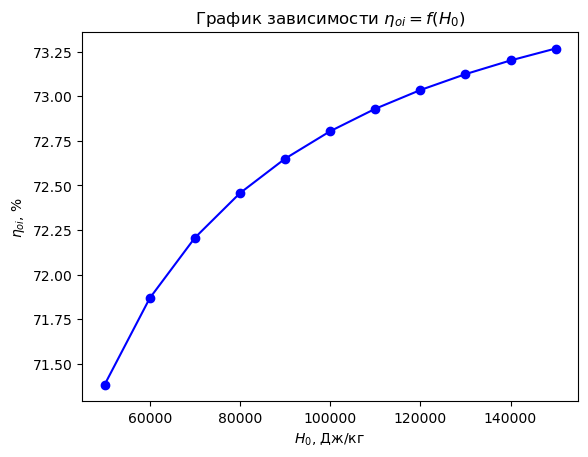

In [19]:
import matplotlib.pyplot as plt
plt.xlabel(r"$H_0$, Дж/кг ")
plt.ylabel(r'$\eta_{oi}$, %')
plt.plot(H_0,eff, "o", color="blue")
plt.plot(H_0,eff, color="blue")
plt.title("График зависимости $\eta_{oi} = f(H_0)$")
plt.show()